<center><b><font size=6>Lab-8 <b><center>
<center><b><font size=6>    Supervised learning with model selection, validation and hyper-parameter tuning<b><center>

### Objective: Applying the following techniques for supervised learning
1. **Validation curve** plots performance score over a single varying hyper-parameter. Therefore, we will also need to perform model validation, with a validation set or with cross-validation. 
2. **Grid search** analyzes the combination of different hyper-parameters. It traverses all the possible combinations of selected values for selected hyper-parameters, training a hypothesis and examining the corresponding performance, eventually outputting the best parameter setting. We need to perform model validation, with a validation set or with cross-validation. 
3. **Learning curve** studies the minimum amount of training samples needed to produce acceptable performance. This is helpful to understand if more data would likely improve the results, or if less data is already enough. We need to perform model validation also on the learning curve.

In [1]:
# import needed python libraries

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import math
import copy

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_validate, StratifiedShuffleSplit

### 1. Tutorial - advanced classification

In [2]:
# load dataset of IRIS flowers
from sklearn import datasets
iris_data = datasets.load_iris()
features_iris = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
df_iris = pd.DataFrame(iris_data.data, columns = features_iris)
df_iris['type'] = 'setosa'
df_iris.loc[50:99, 'type'] = 'versicolor'
df_iris.loc[100:149, 'type'] = 'virginica'

# note that we need to convert the type of flowers to numerical labels
df_iris['label'] = pd.Categorical(df_iris['type']).codes

# data segmentation
# we still split the dataset into training and test sets with portions of 70% and 30% for now
# but in the later stage, you need to further split the training set into training and validation sets
# therefore, we do not name training set as X_train and y_train, but X and y
X, X_test, y, y_test = train_test_split(
    df_iris[features_iris], 
    df_iris['label'], 
    stratify = df_iris['label'], 
    train_size = 0.7, 
    random_state = 15
)

#### Two approaches for model validation
The Test set is always excluded during model development, and in order to consolidate the model selection and tuning, we need a validation set to evaluate the performance as an intermediate outcome. However, ML models are sensitive to data so that the outcome might be too dependant on a certain segmentation of data if you always stick to the same training and validation sets. Therefore, to better evaluate the model, we can repeat the process multiple times using different data to train and validate the model, and then averaging the metrics to derive an overall unbiased performance of the model (but notice that the obtained hypothesis might be different).

There are multiple ways, and here we introduce two of them.

1. k-fold cross-validation: 
    - After setting apart the test set, you split the data into k-folds (k blocks). 
    - We select one fold for validation and we train on all the remaining folds.  
    - We repeat the process k times, each time with a different validation fold. 
    - During each trial, you record the metrics and finally, you can calculate the min, max, mean value of the metrics to evaluate the model performance.
2. Randomly stratified sampling:
    - After setting apart the test set, you randomly split the remaining data in a stratified way (usually according to the label) into training and validation with a certain proportion (e.g., 70% and 30%)
    - You repeat the random split multiple times. In each trial, you end up with somewhat different data segmentation. 
    - During each trial, you record the metrics and finally, you can calculate the min, max, mean value of the metrics to evaluate the model performance.

<center><img src="validation.png" width="vp"/></center>

### 1.1 Validation curve
One way to find the best value of an hyper-parameter of a model (keeping the other ones constant) is the validation curve. It evaluates the model performance on validation set as we change the value of a certain hyper-parameters. Note that you can also simplify the work by using the ``validation_curve()`` (<a href="https://scikit-learn.org/stable/modules/learning_curve.html">documentation</a>) provided by sklearn to do everything in one shot without manually setting up the for loop.

Here we are finding the best value for max_depth in a RandomForestClassifier between 2 and 9, by using cross validation with 5 folds. Use as a metric the accuracy.

Note: the function ``cross_validate`` automatically handles the data segmentation into training and validation sets, but it is possible to do it manually.

In [3]:
acc_train_means = []
acc_train_maxs = []
acc_train_mins = []
acc_val_means = []
acc_val_maxs = []
acc_val_mins = []

#we choose the model RandomForestClassifier and change its hyper-parameter max_depth, using integer values from 2 to 9
for n in range(2, 10):
    rf_clf = RandomForestClassifier(max_depth=n)
    scores = cross_validate(rf_clf, X, y, cv=5, scoring='accuracy', return_train_score=True)
    acc_train_means.append(scores['train_score'].mean())
    acc_train_maxs.append(scores['train_score'].max())
    acc_train_mins.append(scores['train_score'].min())
    acc_val_means.append(scores['test_score'].mean())
    acc_val_maxs.append(scores['test_score'].max())
    acc_val_mins.append(scores['test_score'].min())

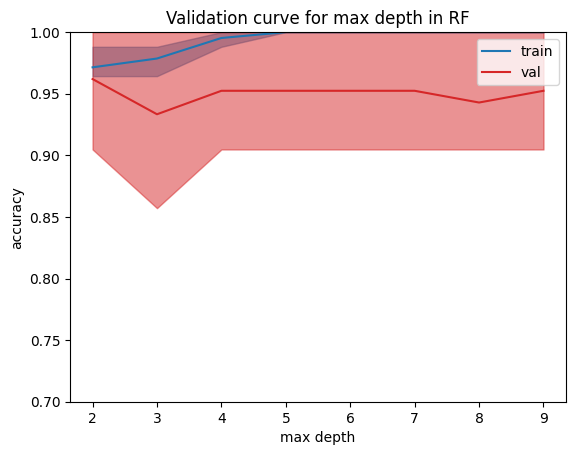

In [4]:
plt.figure()
x = list(range(2, 10))
plt.plot(x, acc_train_means, color='tab:blue', label='train')
plt.fill_between(x, acc_train_mins, acc_train_maxs, alpha=0.5, color='tab:blue')
plt.plot(x, acc_val_means, color='tab:red', label='val')
plt.fill_between(x, acc_val_mins, acc_val_maxs, alpha=0.5, color='tab:red')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.legend()
plt.title("Validation curve for max depth in RF")
plt.ylim(0.7,1)
plt.show()

### 1.2 Grid search
The grid search exhaustively use all combinations of candidates from a grid of hyper-parameter values. It is used to identify the best combinations of ML hyper-parameters for a task, and can be used either for supervised or unsupervised learning problems. First, you select a bunch of hyper-parameters that you want to optimize, and for each of them, determine its value range. Then, the grid search will iterate over all the possible combinations of values of hyper-parameters, building and evaluating a model on each of them, and eventually choosing the one with best performance. Note that we are not doing a cross validation for simplicity, but you can also use ``GridSearchCV`` (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">documentation</a>) provided by sklearn to do it in one line of code.

Here we are finding the best combination of values for max_depth and n_estimators in a RandomForestClassifier, by using a single validation set. We use the accuracy metric to compare the performance.

For using a single validation set, we further split the previous ``X`` and ``y`` into training and validation sets, so that their occupation in the original dataset will be 50% and 20%.

In [5]:
# note that here we do not perform standardization for simplicity
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    stratify = y, 
    train_size = 0.5/0.7, 
    random_state = 15
)

In [6]:
# e.g., RF - parameters to be optimized:
    # n_estimators: number of trees
    # max_depth: the maximum depth of trees

# iterate over all possible combinations
for n_estimators in range(10, 50, 10):
    for max_depth in [2, 3, 4, 5, None]:
        # initialize and fit a model per pair of parameters
        rf_tmp = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=12)
        rf_tmp.fit(X_train, y_train)
        # here we only refer to accuracy for simplicity
        acc_train = accuracy_score(y_train, rf_tmp.predict(X_train))
        acc_val = accuracy_score(y_val, rf_tmp.predict(X_val))
        print(f'#trees: {n_estimators}, max depth: {max_depth}, accuracy: train - {acc_train} | val - {acc_val}')

#trees: 10, max depth: 2, accuracy: train - 0.9866666666666667 | val - 0.9
#trees: 10, max depth: 3, accuracy: train - 0.9866666666666667 | val - 0.9
#trees: 10, max depth: 4, accuracy: train - 1.0 | val - 0.9
#trees: 10, max depth: 5, accuracy: train - 1.0 | val - 0.9
#trees: 10, max depth: None, accuracy: train - 1.0 | val - 0.9
#trees: 20, max depth: 2, accuracy: train - 0.9866666666666667 | val - 0.9
#trees: 20, max depth: 3, accuracy: train - 0.9866666666666667 | val - 0.9
#trees: 20, max depth: 4, accuracy: train - 1.0 | val - 0.9
#trees: 20, max depth: 5, accuracy: train - 1.0 | val - 0.9
#trees: 20, max depth: None, accuracy: train - 1.0 | val - 0.9
#trees: 30, max depth: 2, accuracy: train - 0.9866666666666667 | val - 0.9333333333333333
#trees: 30, max depth: 3, accuracy: train - 0.9866666666666667 | val - 0.9333333333333333
#trees: 30, max depth: 4, accuracy: train - 1.0 | val - 0.9
#trees: 30, max depth: 5, accuracy: train - 1.0 | val - 0.9
#trees: 30, max depth: None, accur

### 1.3 Learning curves
The learning curve shows how performance changes by varying (i.e., reducing) the available data points (e.g., sample size, number of features).

Normally, we need a sampling strategy to create subsets of the data, and such data should be representative. Available sampling strategies are arithmetic sampling, geometric sampling, random sampling, etc. 

You can start with a small portion of the original data to train the model and check the performance, and then keep increasing the portion, observing the performance with respect to the amount of data. Note that, given a value of the portion, the sampling randomly selects data, possibly impacting performance. Therefore, to take it into consideration we can use multiple random states to sample data and computing the statistics of performance (mean, max, min). 

Here we are using a Decision Tree classifier with default hyper-parameters. Start from a subset of training set containing 10% of the data up to 90%. Use randomly stratified sampling and repeat the computation 10 times for each subset with a different initialization state.  Use as a metric the accuracy.

In [9]:
# here we only refer to accuracy for simplicity
info_accuracy_train = []
info_accuracy_val = []

for train_size in np.arange(0.1, 1, 0.1):
    # select 10 random states
    random_states = set()
    while len(random_states) < 10:
        n = random.randint(0,1000000)
        random_states.add(n)

    accuraries_train_tmp = []
    accuraries_val_tmp = []
    
    # iterate over all random states with same training size to derive the 10 different performance
    for random_state in random_states:
        # do a stratified random sampling from the training set 
        sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, random_state=random_state)
        index_selected = list(sss.split(X_train, y_train))[0][0]
        X_train_selected = X_train.iloc[index_selected]
        y_train_selected = y_train.iloc[index_selected]
        
        # initialize and fit a DT model per time
        dt_tmp = DecisionTreeClassifier(random_state=0)
        dt_tmp.fit(X_train_selected, y_train_selected)
        accuraries_train_tmp.append(accuracy_score(y_train_selected, dt_tmp.predict(X_train_selected)))
        accuraries_val_tmp.append(accuracy_score(y_val, dt_tmp.predict(X_val)))

    # calculate the statistics to generate overall performance
    accuraries_tmp = np.array(accuraries_train_tmp)
    mean_acc = accuraries_tmp.mean()
    min_acc = accuraries_tmp.min()
    max_acc = accuraries_tmp.max()
    info_accuracy_train.append((mean_acc, min_acc, max_acc))
    
    accuraries_tmp = np.array(accuraries_val_tmp)
    mean_acc = accuraries_tmp.mean()
    min_acc = accuraries_tmp.min()
    max_acc = accuraries_tmp.max()
    info_accuracy_val.append((mean_acc, min_acc, max_acc))

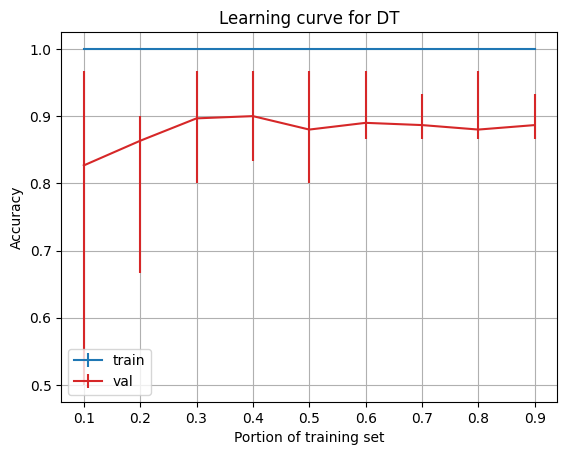

In [10]:
plt.figure()
plt.errorbar(
    [train_size for train_size in np.arange(0.1, 1.0, 0.1)], # x-location of each error bar
    [info[0] for info in info_accuracy_train], # y-location of each error bar
    # the size of each error bar
    yerr=[
        [info[0]-info[1] for info in info_accuracy_train], 
        [info[2]-info[0] for info in info_accuracy_train]
    ], 
    color='tab:blue', label='train'
)
plt.errorbar(
    [train_size for train_size in np.arange(0.1, 1.0, 0.1)], # x-location of each error bar
    [info[0] for info in info_accuracy_val], # y-location of each error bar
    # the size of each error bar
    yerr=[
        [info[0]-info[1] for info in info_accuracy_val], 
        [info[2]-info[0] for info in info_accuracy_val]
    ], 
    color='tab:red', label='val'
)
plt.grid()
plt.xlabel('Portion of training set')
plt.ylabel('Accuracy')
plt.title('Learning curve for DT')
plt.legend()
plt.show()

### 2. Exercise - RTP dataset
In this exercise, we employ the same RTP dataset as in the previous laboratory, but we focus on multi-class classification instead of the binary one. The classes are **Audio, FEC-Audio, High Quality Video, Medium Quality Video, Low Quality Video, FEC-Video, and Screen Sharing**. 

You will:
- Load the dataset
- Perform necessary data processing
- Perform validation curve for k-NN classifier
- Perform grid search for decision tree classifier
- Choose one of the models with best hyper-parameters
- With this model and hyper-parameters, draw a learning curve

In [25]:
# load the dataset
df = pd.read_csv("RTP_dataset.csv")
df

,interarrival_std,interarrival_mean,interarrival_min,interarrival_max,interarrival_max_min_diff,interarrival_p10,interarrival_p20,interarrival_p25,interarrival_p30,interarrival_p40,...,rtp_interarrival_max_min_R,rtp_interarrival_kurtosis,rtp_interarrival_skew,rtp_interarrival_moment3,rtp_interarrival_moment4,rtp_interarrival_len_unique_percent,rtp_interarrival_max_value_count_percent,rtp_interarrival_min_max_R,rtp_marker_sum_check,label
0,0.001927,0.010000,0.004951,0.014423,0.009472,7.619953e-05,8.045912e-05,8.572698e-05,9.030223e-05,9.799051e-05,...,0.500000,-3.000000,0.000000,0.000000e+00,0.000000e+00,0.010000,1.000000,0.500000,0,Audio
1,0.000515,0.020009,0.019227,0.021251,0.002024,1.931565e-04,1.953020e-04,1.958430e-04,1.965890e-04,1.985469e-04,...,0.500000,-3.000000,0.000000,0.000000e+00,0.000000e+00,0.020000,1.000000,0.500000,0,Audio
2,0.041315,0.019994,0.000000,0.143393,0.143393,9.536743e-09,9.536743e-09,9.536743e-09,1.907349e-08,4.053116e-08,...,0.500000,-3.000000,0.000000,0.000000e+00,0.000000e+00,0.019231,1.000000,0.500000,0,Audio
3,0.008119,0.019954,0.000873,0.044432,0.043559,9.701633e-05,1.477895e-04,1.699674e-04,1.779909e-04,1.895509e-04,...,0.500000,-3.000000,0.000000,0.000000e+00,0.000000e+00,0.020000,1.000000,0.500000,0,Audio
4,0.018683,0.020117,0.000001,0.121093,0.121092,1.023531e-05,7.453918e-05,1.209468e-04,1.324451e-04,1.531601e-04,...,0.500000,-3.000000,0.000000,0.000000e+00,0.000000e+00,0.021739,1.000000,0.500000,0,Audio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139995,0.000799,0.337698,0.336812,0.338365,0.001553,3.370330e-03,3.372540e-03,3.373646e-03,3.374751e-03,3.376961e-03,...,0.511905,-1.500000,-0.707107,-2.211840e+08,3.185050e+11,0.666667,0.666667,0.488095,3,ScreenSharing
139996,0.159892,0.239946,0.000108,0.320163,0.320055,9.596729e-04,1.918266e-03,2.397562e-03,2.876859e-03,3.196862e-03,...,1.000000,-0.671026,-1.148811,-2.524719e+12,6.654528e+16,1.000000,0.250000,0.000000,3,ScreenSharing
139997,0.045574,0.040176,0.000012,0.151814,0.151802,1.705837e-05,3.843689e-05,6.171942e-05,1.125135e-04,2.727780e-04,...,0.500000,-3.000000,0.000000,0.000000e+00,0.000000e+00,0.043478,1.000000,0.500000,23,ScreenSharing
139998,0.028728,0.325410,0.299745,0.356444,0.056699,3.038041e-03,3.078630e-03,3.098925e-03,3.119220e-03,3.159810e-03,...,0.511144,-1.500000,-0.695813,-1.628640e+08,2.163721e+11,1.000000,0.333333,0.488856,3,ScreenSharing


### 2.1 Dataset processing
1. Do a single stratified split based on the labels to segment the dataset into training and test sets with portions of 70% and 30% (the validation set will be needed later on, and in that case, you will have to further split the training set).
2. Standardize the dataset by fitting the scaler on training set and then transforming the entire dataset.
3. Repeat the process of removing correlated features, as you have done in the previous lab, examining the correlation in training set and then removing the correlated ones from all datasets.

In [26]:
# This part is already provided
# Here, it is basically the same that you have done during the previous lab except that you are dealing with multiple classes

# Prepare the dataset extracting Features (X) and Labels (Y) 
# Stratify the dataset by having 70% of the data in the training set and 30% in the test set
df_copy = df.copy()
df_copy['label'] = pd.Categorical(df_copy['label']).codes # transform to numerical labels
X = df_copy.drop(columns=['label']).to_numpy()
y = df_copy[['label']].to_numpy()

# Run stratified training-test splitting
# Herem X and y are needed for further split when validation set is needed, while test set is withheld to be evaluate at the very last
X, X_test, y, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=15)
y, y_test = np.ravel(y), np.ravel(y_test)

# Standardize data
scaler = StandardScaler()
scaler.fit(X)
X_s, X_test_s = scaler.transform(X), scaler.transform(X_test)

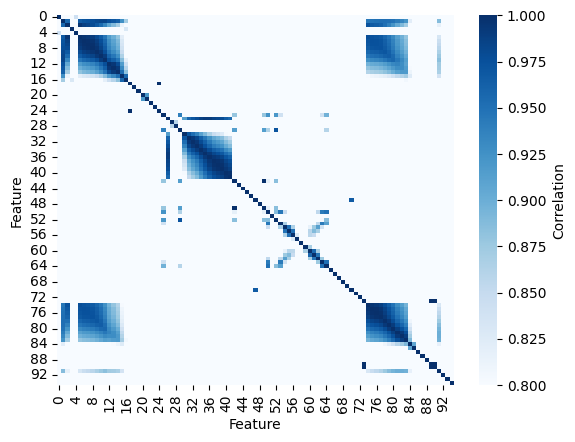

59 features are removed


In [27]:
# compute the correlation matrix
columns= [i for i in range(X_s.shape[1])]
df_tmp = pd.DataFrame(X_s, columns=columns)
correlation_matrix = df_tmp.corr().abs()

# display the heatmap
plt.figure()
sns.heatmap(correlation_matrix, cmap='Blues', vmin=0.8, vmax=1, cbar_kws={'label':'Correlation'})
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.show()

# extract features having a correlation > 0.8
c = correlation_matrix[correlation_matrix>0.8]
s = c.unstack()
so = s.sort_values(ascending=False).reset_index()

# get strongly correlated features removing pairs having correlation = 1 because of the diagonal, i.e., correlation between one feature and itself
so = so[(so[0].isnull()==False) & (so["level_0"] != so["level_1"])]

to_be_deleted = []
candidates = list(so["level_0"])

# get the unique set of features to be deleted. Notice that we discard one feature per time considering the case where a feature is strongly correlated with multiple features
subset_so = so
for candidate in candidates:
    if (candidate in list(subset_so["level_0"])): 
        to_be_deleted.append(candidate)
        subset_so = subset_so[(subset_so["level_0"] != candidate) & (subset_so["level_1"] != candidate)]

# to_be_deleted contains the index of columns that you need to remove from both training and test sets
print(len(to_be_deleted), 'features are removed')

# remove the correlated features from bot sets

# Create a mask for the columns to keep
columns_to_keep = np.ones(X_s.shape[1], dtype=bool)
columns_to_keep[to_be_deleted] = False

# Use the mask to select only the columns to keep
X_s = X_s[:, columns_to_keep]
X_test_s = X_test_s[:, columns_to_keep]

### 2.2 Validation curve
1. Use GaussianNB classifier. For the hyper-parameter `var_smoothing` (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html">documentation</a>) , define a range of possible values, for example ``np.logspace(-4,0,5)``.
2. For each value of `var_smoothing`, for validation use k-fold cross-validation or stratified random sampling for k times. **Note that, no matter which one do you choose, you need to stick to it for the following questions. Choose a low value for k, for example 5**
3. Record the max, min, and mean for each value of the hyper-parameter, and finally plot the performance.
    - What is the best value of `var_smoothing`?

In [14]:
info_accuracy_train = []
info_accuracy_val = []

for var in np.logspace(-4,0,5):
    random_states = set()
    while len(random_states) < 5:
        n = random.randint(0,1000000)
        random_states.add(n)

    accuraries_train_tmp = []
    accuraries_val_tmp = []
    
    # iterate over all random states with same training size to derive the 10 different performance
    for random_state in random_states:
        # further split into training and validation
        X_train_s, X_val_s, y_train, y_val = train_test_split(
            X_s, y, 
            stratify = y, 
            train_size = 0.5/0.7, 
            random_state = random_state
        )
        
        knn_clf = GaussianNB(var_smoothing=var)
        knn_clf.fit(X_train_s, y_train)
        accuraries_train_tmp.append(accuracy_score(y_train, knn_clf.predict(X_train_s)))
        accuraries_val_tmp.append(accuracy_score(y_val, knn_clf.predict(X_val_s)))
        
    # calculate the statistics to generate overall performance
    accuraries_tmp = np.array(accuraries_train_tmp)
    mean_acc = accuraries_tmp.mean()
    min_acc = accuraries_tmp.min()
    max_acc = accuraries_tmp.max()
    info_accuracy_train.append((mean_acc, min_acc, max_acc))
    
    accuraries_tmp = np.array(accuraries_val_tmp)
    mean_acc = accuraries_tmp.mean()
    min_acc = accuraries_tmp.min()
    max_acc = accuraries_tmp.max()
    info_accuracy_val.append((mean_acc, min_acc, max_acc))
    print(f'var={var}, avg_acc={mean_acc}, ,min-acc={min_acc}, max-acc={max_acc}')

var=0.0001, avg_acc=0.8388785714285714, ,min-acc=0.8330357142857143, max-acc=0.8525714285714285
var=0.001, avg_acc=0.8337428571428571, ,min-acc=0.8318571428571429, max-acc=0.8356071428571429
var=0.01, avg_acc=0.8289357142857142, ,min-acc=0.8269285714285715, max-acc=0.8329285714285715
var=0.1, avg_acc=0.8125714285714285, ,min-acc=0.80625, max-acc=0.8306785714285714
var=1.0, avg_acc=0.6711785714285714, ,min-acc=0.6608214285714286, max-acc=0.7041785714285714


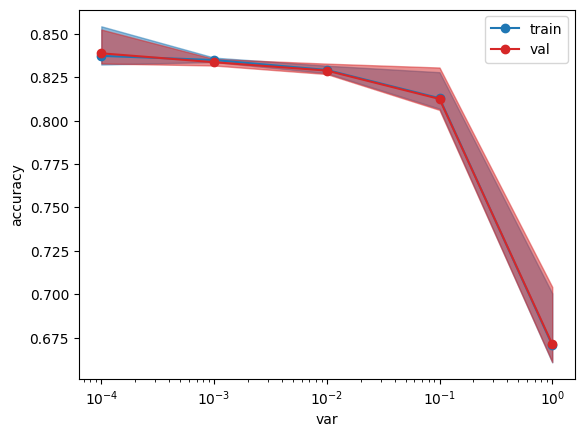

In [15]:
plt.figure()
x =  np.logspace(-4,0,5)
plt.plot(x, [info_accuracy_train[i][0] for i in range(len(x))],'-o', color='tab:blue', label='train')
plt.fill_between(
    x, 
    [info_accuracy_train[i][1] for i in range(len(x))], 
    [info_accuracy_train[i][2] for i in range(len(x))], 
    alpha=0.5, 
    color='tab:blue'
)
plt.plot(x, [info_accuracy_val[i][0] for i in range(len(x))],'-o', color='tab:red', label='val')
plt.fill_between(
    x, 
    [info_accuracy_val[i][1] for i in range(len(x))], 
    [info_accuracy_val[i][2] for i in range(len(x))], 
    alpha=0.5, 
    color='tab:red'
)
plt.xscale('log')
plt.xlabel('var')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### 2.3 Grid search for decision tree

1. Define the parameters' range (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier">documentation</a>) as following:
   - ``criterion`` - ``['gini', 'entropy']``,
   - ``max_depth`` - ``[4, 8, None]``,
   - ``min_samples_split`` - ``[2, 4]``,
2. Perform the grid search among all the possible combinations of the defined parameters' range, and for each combination of configurations:
    - Refer to the approach (k-fold cross-validation or randomly data segmentation for k times) you select in the previous question.
    - Initialize and train the model with the choosing parameters, and evaluate the performance on training and validation set. Record the accuracy of for both sets.
    - After the process, plot the accuracy for training and validation sets with respect to different configuration of parameters (on y-axis, output accuracy with either error bar or filled region between min and max, and on x-axis, specify the configuration index). In the figure, specify the best configuration by mark the highest mean accuracy on validation set.
3. At last, answer the following questions:
    - What is the best combination of parameters?
    - Try to explain why such parameters generate the best outcome. 

In [28]:
%%time
# iterate over all possible combinations
best_combination = [0,1,2,3]
acc_max = 0
idx = -1
idx_best = idx
info_accuracy_train = []
info_accuracy_val = []

for criterion in ['gini', 'entropy']:
    for max_depth in [4, 8, None]:
        for min_samples_split in [2, 4]:
            idx += 1

            random_states = set()
            while len(random_states) < 5:
                n = random.randint(0,1000000)
                random_states.add(n)
        
            accuraries_train_tmp = []
            accuraries_val_tmp = []
            
            # iterate over all random states with same training size to derive the 10 different performance
            for random_state in random_states:
                # further split into training and validation
                X_train_s, X_val_s, y_train, y_val = train_test_split(
                    X_s, y, 
                    stratify = y, 
                    train_size = 0.5/0.7, 
                    random_state = random_state
                )

                # initialize and fit a model per combination of parameters
                dt_tmp = DecisionTreeClassifier(
                    criterion = criterion, 
                    max_depth = max_depth, 
                    min_samples_split = min_samples_split,
                    random_state = 0
                )
                dt_tmp.fit(X_train_s, y_train)
                accuraries_train_tmp.append(accuracy_score(y_train, dt_tmp.predict(X_train_s)))
                accuraries_val_tmp.append(accuracy_score(y_val, dt_tmp.predict(X_val_s)))
        
            # calculate the statistics to generate overall performance
            accuraries_tmp = np.array(accuraries_train_tmp)
            mean_acc = accuraries_tmp.mean()
            min_acc = accuraries_tmp.min()
            max_acc = accuraries_tmp.max()
            info_accuracy_train.append((mean_acc, min_acc, max_acc))
            
            accuraries_tmp = np.array(accuraries_val_tmp)
            mean_acc = accuraries_tmp.mean()
            min_acc = accuraries_tmp.min()
            max_acc = accuraries_tmp.max()
            info_accuracy_val.append((mean_acc, min_acc, max_acc))

            if mean_acc >= acc_max:
                idx_best = idx
                acc_max = mean_acc
                best_combination[0] = criterion
                best_combination[1] = max_depth
                best_combination[2] = min_samples_split

print('Best:')
print(
    f'criterion: {best_combination[0]}, ' + \
    f'max_depth: {best_combination[1]}, ' + \
    f'min_samples_split: {best_combination[2]}'
)

Best:
criterion: entropy, max_depth: None, min_samples_split: 4
CPU times: user 1min 9s, sys: 452 ms, total: 1min 9s
Wall time: 1min 9s


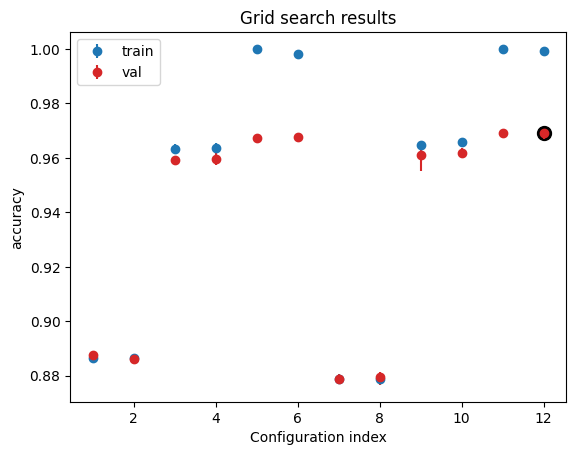

In [29]:
plt.figure()

x = [i for i in range(1, len(info_accuracy_train)+1)]
plt.errorbar(x, [info_accuracy_train[i][0] for i in range(len(info_accuracy_train))],
             yerr=([info_accuracy_train[i][0]-info_accuracy_train[i][1] for i in range(len(info_accuracy_train))],[info_accuracy_train[i][2]-info_accuracy_train[i][0] for i in range(len(info_accuracy_train))]),
             marker='o',
             color='tab:blue', label='train',linestyle='')
plt.errorbar(x, [info_accuracy_val[i][0] for i in range(len(info_accuracy_val))],
             yerr=([info_accuracy_val[i][0]-info_accuracy_val[i][1] for i in range(len(info_accuracy_val))],[info_accuracy_val[i][2]-info_accuracy_val[i][0] for i in range(len(info_accuracy_val))]),
             marker='o',
             color='tab:red', label='val',linestyle='')
plt.title("Grid search results")
plt.xlabel('Configuration index')
plt.ylabel('accuracy')
plt.legend()

plt.scatter(idx_best+1, acc_max, marker='o', color='black',s=100)

plt.show()

### 2.4 Learning Curve
Once we find the best features and configurations, we can check the number of training samples required to create a reliable model by checking learning curve.
1. Select the best one of the previous models with the best configuration. Define the range of portion of training sample. Note that this is the portion of training samples out of the dataset used for model training (test set is excluded). The goal is to find the proper portion that can generate an accuracy on validation greater than a certain threshold, e.g., 96%, and to see whether it is needed to gather more data.
2. For each of the percentage in the range, refer to your previous selected approach (k-fold cross-validation or random stratified sampling for k times) and train your model with different portions of training set.
3. At each trial, record the accuracy, calculating the max, min and mean among the k repetitions.
4. Visualize the performance evolution with error bar as you increase the portion of training data.
    - Which portion do you think is proper to derive a reliable result?
    - Do you think whether we need more data?

In [30]:
info_accuracy_train = []
info_accuracy_val = []

for train_size in np.arange(0.1, 1.0, 0.1):
    # select 5 random states
    random_states = set()
    while len(random_states) < 5:
        n = random.randint(0,1000000)
        random_states.add(n)

    accuraries_train_tmp = []
    accuraries_val_tmp = []
    
    # iterate over all random states with same training size to derive the 10 different performance
    for random_state in random_states:

        # further split into training and validation
        X_train_s, X_val_s, y_train, y_val = train_test_split(
            X_s, y, 
            stratify = y, 
            train_size = train_size, 
            random_state = random_state
        )
        
        dt_tmp = DecisionTreeClassifier(
            criterion = best_combination[0], 
            max_depth = best_combination[1], 
            min_samples_split = best_combination[2],
            max_features = best_combination[3],
            random_state = 0
        )
        dt_tmp.fit(X_train_s, y_train)
        accuraries_train_tmp.append(accuracy_score(y_train, dt_tmp.predict(X_train_s)))
        accuraries_val_tmp.append(accuracy_score(y_val, dt_tmp.predict(X_val_s)))
    
    # calculate the statistics to generate overall performance
    accuraries_tmp = np.array(accuraries_train_tmp)
    mean_acc = accuraries_tmp.mean()
    min_acc = accuraries_tmp.min()
    max_acc = accuraries_tmp.max()
    info_accuracy_train.append((mean_acc, min_acc, max_acc))
    
    accuraries_tmp = np.array(accuraries_val_tmp)
    mean_acc = accuraries_tmp.mean()
    min_acc = accuraries_tmp.min()
    max_acc = accuraries_tmp.max()
    info_accuracy_val.append((mean_acc, min_acc, max_acc))

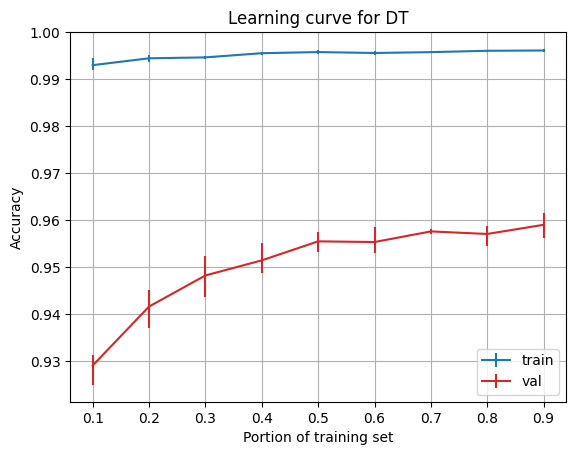

In [31]:
plt.figure()

plt.errorbar(
    [train_size for train_size in np.arange(0.1, 1.0, 0.1)], # x-location of each error bar
    [info_accuracy_train[i][0] for i in range(len(info_accuracy_train))], # y-location of each error bar
    # the size of each error bar
    yerr = [
        [info_accuracy_train[i][0]-info_accuracy_train[i][1] for i in range(len(info_accuracy_train))], 
        [info_accuracy_train[i][2]-info_accuracy_train[i][0] for i in range(len(info_accuracy_train))]
    ],
    color='tab:blue',
    label='train'
)

plt.errorbar(
    [train_size for train_size in np.arange(0.1, 1.0, 0.1)], # x-location of each error bar
    [info_accuracy_val[i][0] for i in range(len(info_accuracy_val))], # y-location of each error bar
    # the size of each error bar
    yerr = [
        [info_accuracy_val[i][0]-info_accuracy_val[i][1] for i in range(len(info_accuracy_val))], 
        [info_accuracy_val[i][2]-info_accuracy_val[i][0] for i in range(len(info_accuracy_val))]
    ],
    color='tab:red',
    label='val'
)
plt.grid()
plt.xlabel('Portion of training set')
plt.ylabel('Accuracy')
plt.title("Learning curve for DT")
plt.legend()
plt.show()

### 2.5 Test your best model on unseen data
Based on the previous considerations, retrain your model with all of the aforementioned best selections on all data except test set. Output the final performance in terms of classification report and confusion matrix  on the test set.
- Which classes have good performance?
- Which classes have poor performance?
- Can you find some peculiar behavior for the performance of certain classes? Try to explain why.

In [32]:
dt_final = DecisionTreeClassifier(
    criterion = best_combination[0], 
    max_depth = best_combination[1], 
    min_samples_split = best_combination[2],
    max_features = best_combination[3],
    random_state = 0
)
dt_final.fit(X_s, y)
y_pred = dt_final.predict(X_test_s)

In [33]:
# Classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6000
           1       1.00      1.00      1.00      6000
           2       0.99      0.99      0.99      6000
           3       0.96      0.96      0.96      6000
           4       0.93      0.93      0.93      6000
           5       0.90      0.90      0.90      6000
           6       0.97      0.98      0.97      6000

    accuracy                           0.96     42000
   macro avg       0.96      0.96      0.96     42000
weighted avg       0.96      0.96      0.96     42000



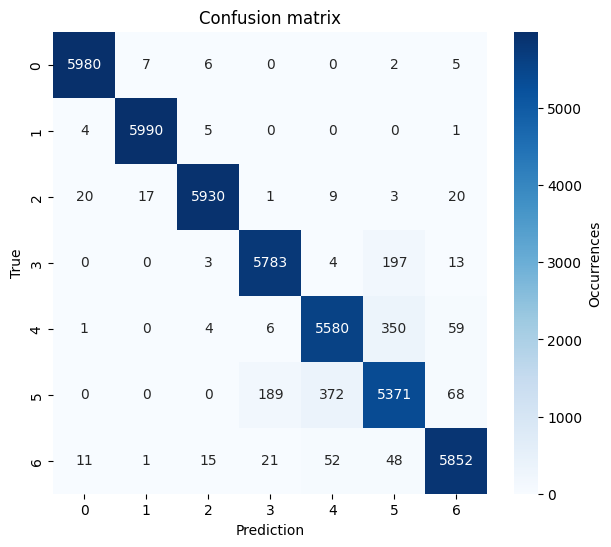

In [34]:
# get the confusion matrix of test set
confusion = confusion_matrix(y_test, y_pred)

# visualize the confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()